# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Load Data

## Import libraries and Requirement things :

#### Configure a NLP

In [5]:
!pip install spacy

   ---------------------------------------- 0.0/11.8 MB ? eta -:--:--
    --------------------------------------- 0.3/11.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.8 MB 1.7 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.8 MB 1.8 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/11.8 MB 1.9 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/11.8 MB 1.9 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/11.8 MB 1.9 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/11.8 MB 1.9 MB/s eta 0:00:06
   ----- ---------------------------------- 1.6/11.8 MB 976.0 kB/s eta 0:00:11
   ------ --------------------------------- 1.8/11.8 MB 987.4 kB/s eta 0:00:11
   -------- ------------------------------- 2.4/11.8 MB 1.1 MB/s eta 0:00:09
   -------- ------------------------------- 2.6/11.8 MB 1.1 MB/s eta 0:00:09
   --------- ------------------------------ 2.9/11.8 MB 1.2 MB/s eta 0:00:08
   ------

In [11]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 3.4 MB/s eta 0:00:04
     - -------------------------------------- 0.5/12.8 MB 3.4 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 1.9 MB/s eta 0:00:07
     ----- ---------------------------------- 1.8/12.8 MB 2.1 MB/s eta 0:00:06
     -------- ------------------------------- 2.6/12.8 MB 2.4 MB/s eta 0:00:05
     --------- ------------------------------ 2.9/12.8 MB 2.2 MB/s eta 0:00:05
     --------- ------------------------------ 2.9/12.8 MB 2.2 MB/s eta 0:00:05
     --------- ------------------------------ 2.9/12.8 MB 2.2 MB/s eta 0:00:05
     ---------- ----------------------------- 3.4/12.8 MB 1.7 MB/s eta 0:00:06
     ----------- ---------------------------- 3.7/12.8 MB 1.7 MB/s eta 0:00:06
     ------------- -------------------------- 4.2/12.8 MB 1.7 MB/s

In [40]:
nlp = spacy.load("en_core_web_sm")

#### Import Libraries :

In [3]:
import matplotlib.pyplot as plt
import spacy
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import datasets
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import train_test_split , HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [7]:
# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
print("Data shape :" , df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 18442 entries, 0 to 18441
,Data columns (total 9 columns):
, #   Column                   Non-Null Count  Dtype 
,---  ------                   --------------  ----- 
, 0   Clothing ID              18442 non-null  int64 
, 1   Age                      18442 non-null  int64 
, 2   Title                    18442 non-null  object
, 3   Review Text              18442 non-null  object
, 4   Positive Feedback Count  18442 non-null  int64 
, 5   Division Name            18442 non-null  object
, 6   Department Name          18442 non-null  object
, 7   Class Name               18442 non-null  object
, 8   Recommended IND          18442 non-null  int64 
,dtypes: int64(4), object(5)
,memory usage: 936.6+ KB
,Data shape : (18442, 9)


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Preparing features (`X`) & target (`y`)

In [3]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
,Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [3]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

# Your Work

## Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 18442 entries, 0 to 18441
,Data columns (total 9 columns):
, #   Column                   Non-Null Count  Dtype 
,---  ------                   --------------  ----- 
, 0   Clothing ID              18442 non-null  int64 
, 1   Age                      18442 non-null  int64 
, 2   Title                    18442 non-null  object
, 3   Review Text              18442 non-null  object
, 4   Positive Feedback Count  18442 non-null  int64 
, 5   Division Name            18442 non-null  object
, 6   Department Name          18442 non-null  object
, 7   Class Name               18442 non-null  object
, 8   Recommended IND          18442 non-null  int64 
,dtypes: int64(4), object(5)
,memory usage: 936.6+ KB


### Distribution of Recommended IND

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 18442 entries, 0 to 18441
,Data columns (total 8 columns):
, #   Column                   Non-Null Count  Dtype 
,---  ------                   --------------  ----- 
, 0   Age                      18442 non-null  int64 
, 1   Title                    18442 non-null  object
, 2   Review Text              18442 non-null  object
, 3   Positive Feedback Count  18442 non-null  int64 
, 4   Division Name            18442 non-null  object
, 5   Department Name          18442 non-null  object
, 6   Class Name               18442 non-null  object
, 7   Recommended IND          18442 non-null  int64 
,dtypes: int64(3), object(5)
,memory usage: 792.5+ KB
,None
,                Age  Positive Feedback Count  Recommended IND
,count  18442.000000             18442.000000     18442.000000
,mean      43.383635                 2.697484         0.816235
,std       12.246264                 5.942220         0.387303
,min       18.000000                 0

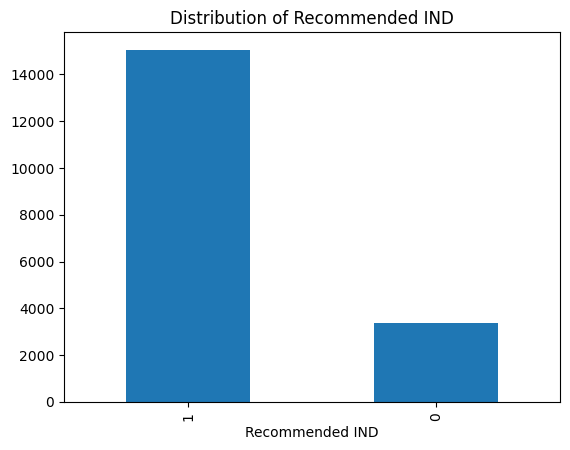

In [9]:
df = data.copy()
df.drop('Clothing ID', axis=1, inplace=True)

print(df.info())

print(df.describe())

df['Recommended IND'].value_counts().plot(kind='bar')
plt.title('Distribution of Recommended IND')
plt.show()

### Correlation Matrix

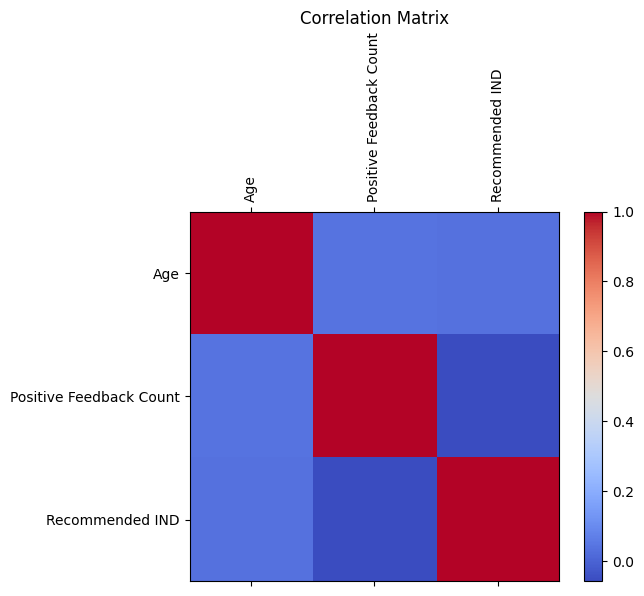

In [15]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix, cmap='coolwarm')
fig.colorbar(cax)
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns.tolist(), rotation=90)
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_yticklabels(corr_matrix.columns.tolist())
plt.title('Correlation Matrix')
plt.show()

### Avg Positive Feedbacks & Number of Reviews by Department (Bar charts)

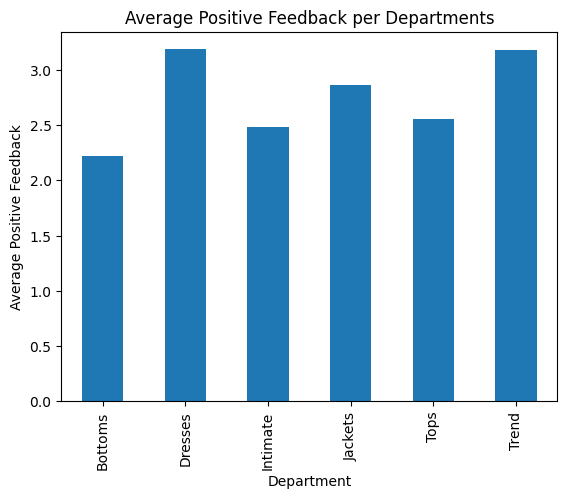

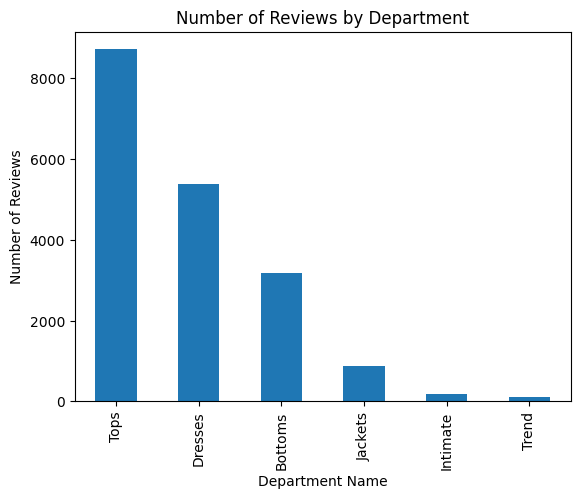

In [18]:
avg_feedback_by_dept = df.groupby('Department Name')['Positive Feedback Count'].mean()

avg_feedback_by_dept.plot(kind= 'bar')
plt.title('Average Positive Feedback per Departments')
plt.xlabel("Department")
plt.ylabel("Average Positive Feedback")
plt.show()

department_counts = df['Department Name'].value_counts()

department_counts.plot(kind='bar')
plt.title('Number of Reviews by Department')
plt.xlabel('Department Name')
plt.ylabel('Number of Reviews')
plt.show()

### Visualization of Age distribution of reviewers

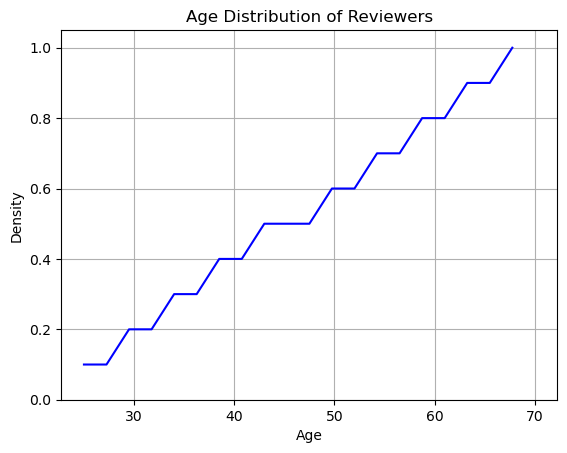

In [33]:
data = {'Age': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70]}
df = pd.DataFrame(data)

density, bins, _ = plt.hist(df['Age'], bins=20, density=True, alpha=0)
cum_density = np.cumsum(density * np.diff(bins))

plt.plot(bins[:-1], cum_density, color="blue")
plt.title('Age Distribution of Reviewers')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)
plt.show()


## Building Pipeline

In [50]:
nlp = spacy.load("en_core_web_sm")

class TextLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lemmatized_texts = [' '.join(token.lemma_ for token in doc if not token.is_stop)
                            for doc in self.nlp.pipe(X)]
        return lemmatized_texts


## Training Pipeline

In [65]:

nlp = spacy.load("en_core_web_sm")

class TextLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join([token.lemma_ for token in doc if not token.is_stop]) for doc in self.nlp.pipe(X)]

text_processing_pipeline = Pipeline([
    ('lemmatizer', TextLemmatizer(nlp=nlp)),
    ('tfidf_vectorizer', TfidfVectorizer(stop_words='english'))
])

feature_engineering = ColumnTransformer([
    ('text_data', text_processing_pipeline, 'Review Text'),
    ('categorical_data', OneHotEncoder(handle_unknown='ignore'), ['Division Name', 'Department Name', 'Class Name'])
], remainder='passthrough')

## Fine-Tuning Pipeline

In [4]:
df = pd.read_csv('data/reviews.csv')

X = df.drop('Recommended IND', axis=1)
y = df['Recommended IND']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english'))

])



categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'Review Text'),
        ('cat', categorical_transformer, ['Division Name', 'Department Name', 'Class Name'])
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid ={
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, 20]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1

)

### Training the model :

In [5]:
grid_search.fit(X_train, y_train)




print("Best parameters found: ", grid_search.best_params_)




best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)




print("Accuracy after hyperparameter tuning:", accuracy_score(y_test, y_pred))
print("Classification Report after tuning:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found:  {'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Accuracy after hyperparameter tuning: 0.8129574410409325
Classification Report after tuning:
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       692
           1       0.81      1.00      0.90      2997

    accuracy                           0.81      3689
   macro avg       0.91      0.50      0.45      3689
weighted avg       0.85      0.81      0.73      3689

